Null-hypothesis significance testing requires a single fitted distribution for the tests statistic of the null hypothesis, in order to calculate the p-values.

Sometimes that is done by choosing the most conservative possible hypothesis. For example, if we want to test whether a drug will add more than a year to someone's life the alternative hypothesis is anything greater than a year. The most conservative null hypothesis – the one hardest to disproved – is that the drug will add exactly one year.

In other cases we don't have full information, so we choose a reasonable null hypothesis. For example, suppose we are asking if two ads have the same click-through rate, the null hypothesis is that those rates are the same. To make a simple distribution, we assume that rate is actually the average rate in our data.

This always seemed arbitrary to me. So my question is, is that null hypothesis (that the population rate is the overall frequency from the data) actually the most conservative hypothesis? (compared to other possibilities). If so, that would be a good reason to choose it.

In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def freq_diff(na, nb, ka, kb):
    return kb/nb - ka/na

In [3]:
def null_hyp(na, nb, p):
    return stats.norm(0, np.sqrt(p * (1-p) * (na+nb) / (na*nb)))

In [4]:
na = 100
nb = 80
ka = 40
kb = 42

In [5]:
fd = freq_diff(na, nb, ka, kb)
null = null_hyp(na, nb, (ka+kb)/(na+nb))

Text(0, 0.5, 'pdf of null hypothesis')

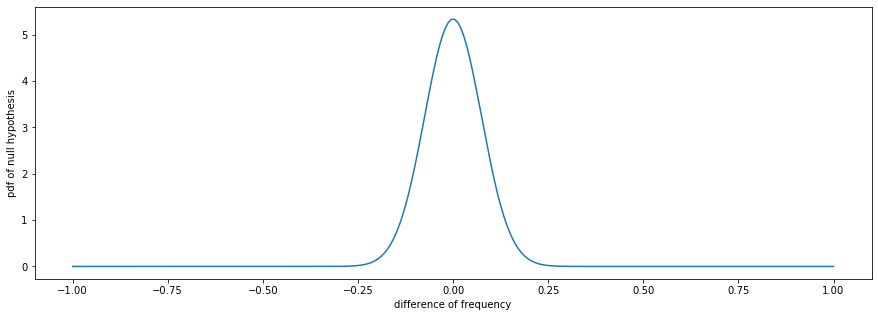

In [6]:
fig, ax = plt.subplots(figsize=(15, 5))
xpts = np.linspace(-1, 1, 250)
ax.plot(xpts, null.pdf(xpts))
ax.set_xlabel("difference of frequency")
ax.set_ylabel("pdf of null hypothesis")

In [7]:
p_values = []
ps = np.linspace(0, 1, 100)
for p in ps:
    null = null_hyp(na, nb, p)
    p_values.append(1-null.cdf(fd))

/Users/jackbennetto/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1745: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


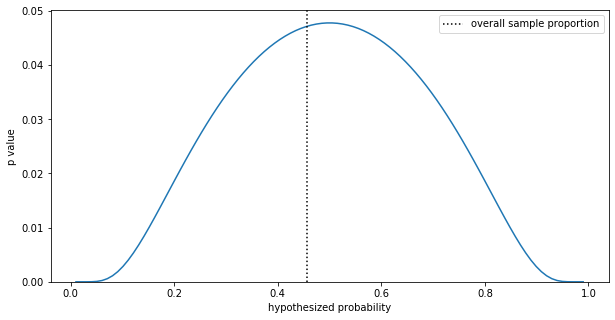

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ps, p_values)
ax.set_xlabel('hypothesized probability')
ax.set_ylabel('p value')
ax.axvline((ka+kb)/(na+nb), c='k', ls=":", label="overall sample proportion")
#ax.axvline(0.5)
ax.set_ylim(ymin=0)
ax.legend()

Answer: I guess not.

### Will choosing the overall proportion from the data affect p-values?

We should be able to simulate this.

In [267]:
p = 0.3
n0 = 5
n1 = 10


We'll do a convolution to subtract the random variables.


In [268]:
def sub_rv(dist0, dist1):
    min0, max0 = dist0.support()
    min1, max1 = dist1.support()
    probs = np.convolve(dist0.pmf(np.arange(min0, max0+1)),
                        dist1.pmf(np.arange(max1, min1-1, -1)))
    #print(dist0.pmf(np.arange(min0, max0+1)))
    #print(dist1.pmf(np.arange(max1, min1-1, -1)))
    #print(min0, max0, min1, max1, len(probs))
    #print(probs)
    diff = stats.rv_discrete(values=(range(min0 - max1, max0-min1+1), probs))
    return diff

In [269]:
dist1.pmf(np.arange(2, -1, -1))

array([0.3125 , 0.15625, 0.03125])

In [270]:
dist1.support()

(0, 5)

In [271]:
dist1.pmf(np.arange(2, -1, -1))

array([0.3125 , 0.15625, 0.03125])

In [272]:
p_values = []
for _ in range(1000):
    success_0 = stats.binom(n0, p).rvs()
    success_1 = stats.binom(n1, p).rvs()
    diff_exp = (success_0 - success_1)
    p_exp = (success_0 + success_1) / (n0 + n1)
    #print(f"p_exp = {p_exp}")
    dist0 = stats.binom(n0, p_exp)
    dist1 = stats.binom(n1, p_exp)

    dist_total = sub_rv(dist0, dist1)
    p_value = dist_total.cdf(diff_exp)
    p_values.append(p_value)

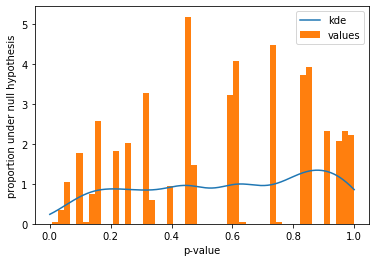

In [278]:
fig, ax = plt.subplots()
kde = stats.gaussian_kde(p_values)
xpts = np.linspace(0, 1, 500)
ax.plot(xpts, kde(xpts), label='kde')
ax.hist(p_values, bins=50, density=True, label='values')
ax.set_xlabel('p-value')
ax.set_ylabel('proportion under null hypothesis')

ax.legend();

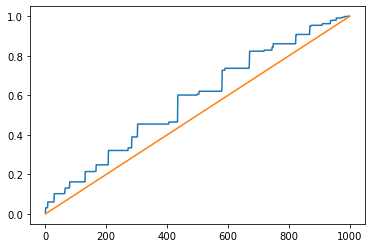

In [276]:
fig, ax = plt.subplots()
p_values.sort()
ax.plot(p_values)
ax.plot([0, len(p_values)], [0, 1])

It's always above the line, but I think that's a factor of the >= in cdf. This problem is a little tricky because it's discrete.